## Comparing distributions

In [13]:
import pandas as pd
import numpy as np
from itertools import product
from scipy.special import rel_entr
numeric_variable_nums = dict([('boston', 12), ('house',8),('sim_1', 0),('sim_2',0), ('sim_1_tiny',0), ('sim_2_tiny',0)])

In [14]:
# generate complete data's conditional distributions
def generate_cond(dataset, mr, size, sample_id, is_vae = False):
    if is_vae:
        complete_data_path = '../vaeac/samples/'+ dataset + '/complete_' + str(mr) + '_' + str(size) + '/sample_' + str(sample_id) + '.csv'
    else:
        complete_data_path = './samples/' + dataset + '/complete_' + str(mr) + '_' + str(size) + '/sample_' + str(sample_id) + '.csv'
    data = pd.read_csv(complete_data_path, header=None)

    # divide cat/num type
    num_index = list(range(data.shape[1] - numeric_variable_nums[dataset], data.shape[1]))
    cat_index = list(range(0, data.shape[1] - numeric_variable_nums[dataset]))

    # get all possible levels' combination for categorical variable
    all_levels = [np.unique(data.iloc[:,i]).tolist() for i in cat_index]
    all_levels_comb = list(product(*all_levels[:-1]))

    # calculate conditional distributions for complete data
    cond_dist_complete = dict.fromkeys(all_levels_comb, None)
    for index, item in data.iterrows():
        cond = (int(item[0]), int(item[1]), int(item[2]))
        if cond_dist_complete[cond] == None:
            cond_dist_complete[cond] = [0 for x in range(len(all_levels[-1]))]
        cond_dist_complete[cond][int(item[3])] += 1

    for key in cond_dist_complete.keys():
        denom = sum(cond_dist_complete[key])
        cond_dist_complete[key] = [round(x / denom, 3) for x in cond_dist_complete[key]]
    
    pdata = data.copy()
    pdata[3] = np.random.permutation(pdata[3])

    return all_levels, all_levels_comb, cond_dist_complete, pdata

In [32]:
# calculate kl result for permutation data
def perm_kl_result(all_levels, all_levels_comb, cond_dist_complete, perm_data):
    cond_dist_imputed = dict.fromkeys(all_levels_comb, None)
    for index, item in perm_data.iterrows():
            cond = (item[0], item[1], item[2])
            if cond_dist_imputed[cond] == None:
                cond_dist_imputed[cond] = [0 for x in range(len(all_levels[-1]))]
            cond_dist_imputed[cond][int(item[3])] += 1

    for key in cond_dist_imputed.keys():
        denom = sum(cond_dist_imputed[key])
        cond_dist_imputed[key] = [round(x / denom, 3) for x in cond_dist_imputed[key]]

    # output comparing KL divergence
    comparison_dict = dict.fromkeys(all_levels_comb, None)
    for key in comparison_dict.keys():
        if cond_dist_imputed[key] == None:
            continue
        comparison_dict[key] = round(sum(rel_entr(cond_dist_complete[key], cond_dist_imputed[key])),6)
    print(list(comparison_dict.values()))
    average_kl = np.average(list(comparison_dict.values()))
    return average_kl, comparison_dict

In [37]:
# output KL divergence for each pair of conditional distribution in one sample
def kl_comparison(method, imputed_data_folder, all_levels, all_levels_comb, cond_dist_complete, sample_id, impute_num):
    # calculate conditional distributions from imputed datasets
    cond_dist_imputed = dict.fromkeys(all_levels_comb, None)
    for i in range(impute_num):
        current_imputed_dir = imputed_data_folder + 'imputed_' + str(sample_id) + '_' + str(i) + '.csv'
        imputed_data = pd.read_csv(current_imputed_dir, header=None)
        for index, item in imputed_data.iterrows():
            if (method == 'cart'):
                item = [int(item[0] - 1), int(item[1] - 1), int(item[2] - 1), int(item[3] - 1)]
            cond = (int(item[0]), int(item[1]), int(item[2]))
            
            if cond_dist_imputed[cond] == None:
                cond_dist_imputed[cond] = [0 for x in range(len(all_levels[-1]))]
            cond_dist_imputed[cond][int(item[3])] += 1

    for key in cond_dist_imputed.keys():
        if cond_dist_imputed[key] == None:
            continue
        denom = sum(cond_dist_imputed[key])
        cond_dist_imputed[key] = [round(x / denom, 3) for x in cond_dist_imputed[key]]

    # output comparing KL divergence
    comparison_dict = dict.fromkeys(all_levels_comb, None)
    for key in comparison_dict.keys():
        if cond_dist_imputed[key] == None:
            continue
        comparison_dict[key] = round(sum(rel_entr(cond_dist_complete[key], cond_dist_imputed[key])),6)
    average_kl = np.average(list(comparison_dict.values()))
    return average_kl, comparison_dict, cond_dist_imputed


In [93]:
# output conditional distribution plots
from matplotlib import pyplot as plt

def cd_plots(cond_dist_complete, cond_dist_imputed, method_list, nrow, ncol, cond = None):
    
    if cond == None:
        x_lab = range(4)
        figure, axes = plt.subplots(nrows=nrow, ncols = ncol, figsize = (15,15))
        axes = axes.reshape(1,-1)
        indx = 0

        for key in cond_dist_complete.keys():
            cond_dist = cond_dist_complete[key]
            compare_data = pd.DataFrame({'Ground Truth': cond_dist})
            for method in method_list:
                imputed_dist = cond_dist_imputed[method][key]
                compare_data[method] = imputed_dist
            compare_data.plot(kind = 'bar', ylim = [0,1], title=str(key), ax = axes[0][indx], legend=False)
            indx += 1
        bar,label = axes[0][0].get_legend_handles_labels()
        figure.legend(bar, label, loc = 'upper right')
        plt.subplots_adjust(hspace=1)
        plt.show()
    
    else:
        x_lab = range(4)
        cond_dist = cond_dist_complete[cond]
        compare_data = pd.DataFrame({'Ground Truth': cond_dist})
        for method in method_list:
            imputed_dist = cond_dist_imputed[method][cond]
            compare_data[method] = imputed_dist
        compare_data = pd.DataFrame({'Ground Truth': cond_dist, 'Imputation': imputed_dist}, 
                                    index=x_lab)
        compare_data.plot(kind = 'bar', ylim = [0,1], title=str(cond))


## sim_1_tiny

In [17]:
# complete data
# readin datasets (complete dataset)
dataset = 'sim_1_tiny'
mr = 0.3
size = 5000
sample_id = 0
impute_num = 10
all_levels, all_levels_comb, cond_dist_complete, perm_data = generate_cond(dataset, mr, size, sample_id)

In [18]:
# rand result
perm_kl_result(all_levels, all_levels_comb, cond_dist_complete, perm_data)

[0.514288, 0.124794, 0.028752, 0.252185, 0.008372, 0.195622, 0.277659, 0.042323, 0.123052, 0.141868, 0.012453, 0.410041, 0.176872, 0.093557, 0.346761, 0.04332, 0.105349, 0.515529]


(0.18959983333333333,
 {(0.0, 0.0, 0.0): 0.514288,
  (0.0, 0.0, 1.0): 0.124794,
  (0.0, 0.0, 2.0): 0.028752,
  (0.0, 1.0, 0.0): 0.252185,
  (0.0, 1.0, 1.0): 0.008372,
  (0.0, 1.0, 2.0): 0.195622,
  (1.0, 0.0, 0.0): 0.277659,
  (1.0, 0.0, 1.0): 0.042323,
  (1.0, 0.0, 2.0): 0.123052,
  (1.0, 1.0, 0.0): 0.141868,
  (1.0, 1.0, 1.0): 0.012453,
  (1.0, 1.0, 2.0): 0.410041,
  (2.0, 0.0, 0.0): 0.176872,
  (2.0, 0.0, 1.0): 0.093557,
  (2.0, 0.0, 2.0): 0.346761,
  (2.0, 1.0, 0.0): 0.04332,
  (2.0, 1.0, 1.0): 0.105349,
  (2.0, 1.0, 2.0): 0.515529})

In [55]:
method_list = ['gain','cart','vaeac']
average_kl = dict.fromkeys(method_list, None)
comparison_dict = dict.fromkeys(method_list, None)
cond_dist_imputed = dict.fromkeys(method_list, None)

for method in method_list:
    imputed_data_folder = './results/' + dataset + '/MCAR_' + str(mr) + '_' + str(size) + '/' + method + '/'
    result = kl_comparison(method,imputed_data_folder,
                         all_levels, all_levels_comb, cond_dist_complete,
                         sample_id, impute_num)
    average_kl[method], comparison_dict[method], cond_dist_imputed[method] = result
    

c:\Users\86157\Anaconda3\envs\jiaxin\lib\site-packages\pandas\plotting\_matplotlib\tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


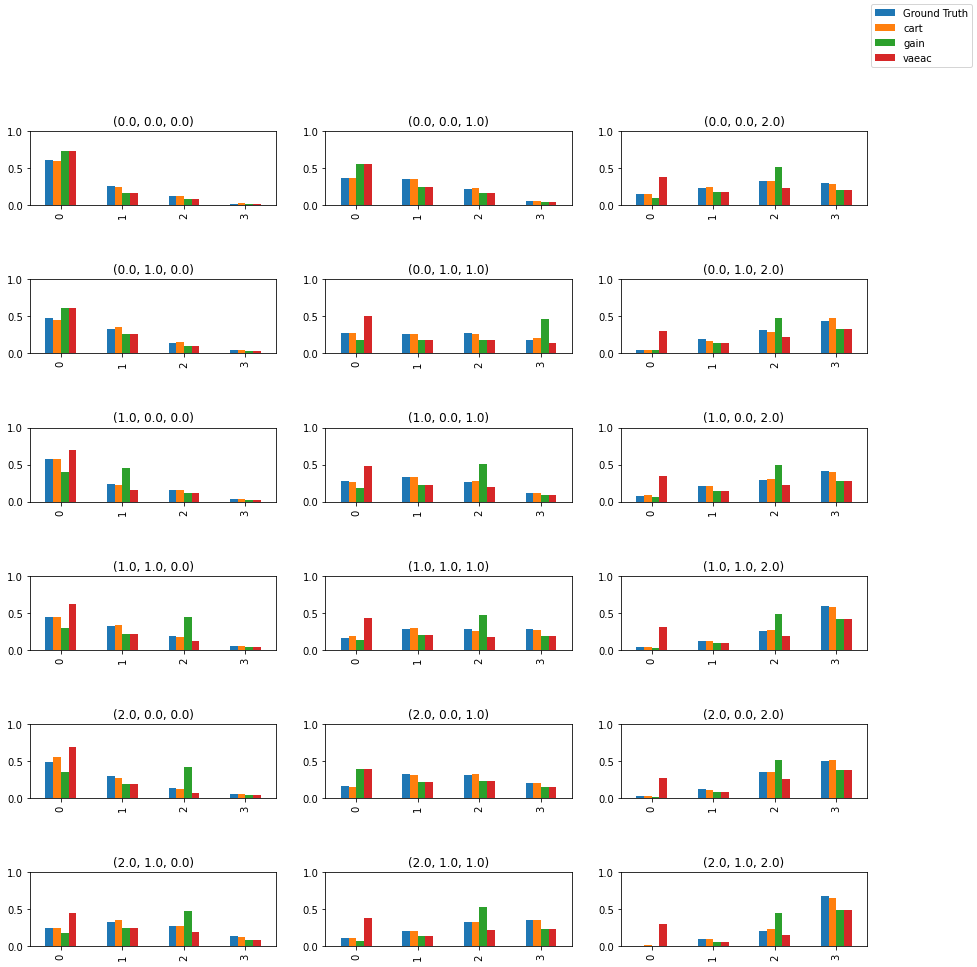

In [95]:
method_list = ['cart','gain','vaeac']
cd_plots(cond_dist_complete, cond_dist_imputed,method_list, 6,3)

## sim_2_tiny

In [96]:
# complete data
# readin datasets (complete dataset)
dataset = 'sim_2_tiny'
mr = 0.3
size = 5000
sample_id = 0
impute_num = 10
all_levels, all_levels_comb, cond_dist_complete, perm_data = generate_cond(dataset, mr, size, sample_id)

In [97]:
# rand result
perm_kl_result(all_levels, all_levels_comb, cond_dist_complete, perm_data)

[0.501049, 0.184096, 0.048039, 0.317445, 0.203406, 0.039488, 0.172183, 0.042954, 0.294492, 0.143788, 0.098521, 0.281797, 0.009497, 0.120277, 0.463432, 0.055698, 0.087001, 0.464126]


(0.19596049999999998,
 {(0.0, 0.0, 0.0): 0.501049,
  (0.0, 0.0, 1.0): 0.184096,
  (0.0, 0.0, 2.0): 0.048039,
  (0.0, 1.0, 0.0): 0.317445,
  (0.0, 1.0, 1.0): 0.203406,
  (0.0, 1.0, 2.0): 0.039488,
  (1.0, 0.0, 0.0): 0.172183,
  (1.0, 0.0, 1.0): 0.042954,
  (1.0, 0.0, 2.0): 0.294492,
  (1.0, 1.0, 0.0): 0.143788,
  (1.0, 1.0, 1.0): 0.098521,
  (1.0, 1.0, 2.0): 0.281797,
  (2.0, 0.0, 0.0): 0.009497,
  (2.0, 0.0, 1.0): 0.120277,
  (2.0, 0.0, 2.0): 0.463432,
  (2.0, 1.0, 0.0): 0.055698,
  (2.0, 1.0, 1.0): 0.087001,
  (2.0, 1.0, 2.0): 0.464126})

In [102]:
method_list = ['gain','cart']
average_kl = dict.fromkeys(method_list, None)
comparison_dict = dict.fromkeys(method_list, None)
cond_dist_imputed = dict.fromkeys(method_list, None)

for method in method_list:
    imputed_data_folder = './results/' + dataset + '/MCAR_' + str(mr) + '_' + str(size) + '/' + method + '/'
    result = kl_comparison(method,imputed_data_folder,
                         all_levels, all_levels_comb, cond_dist_complete,
                         sample_id, impute_num)
    average_kl[method], comparison_dict[method], cond_dist_imputed[method] = result

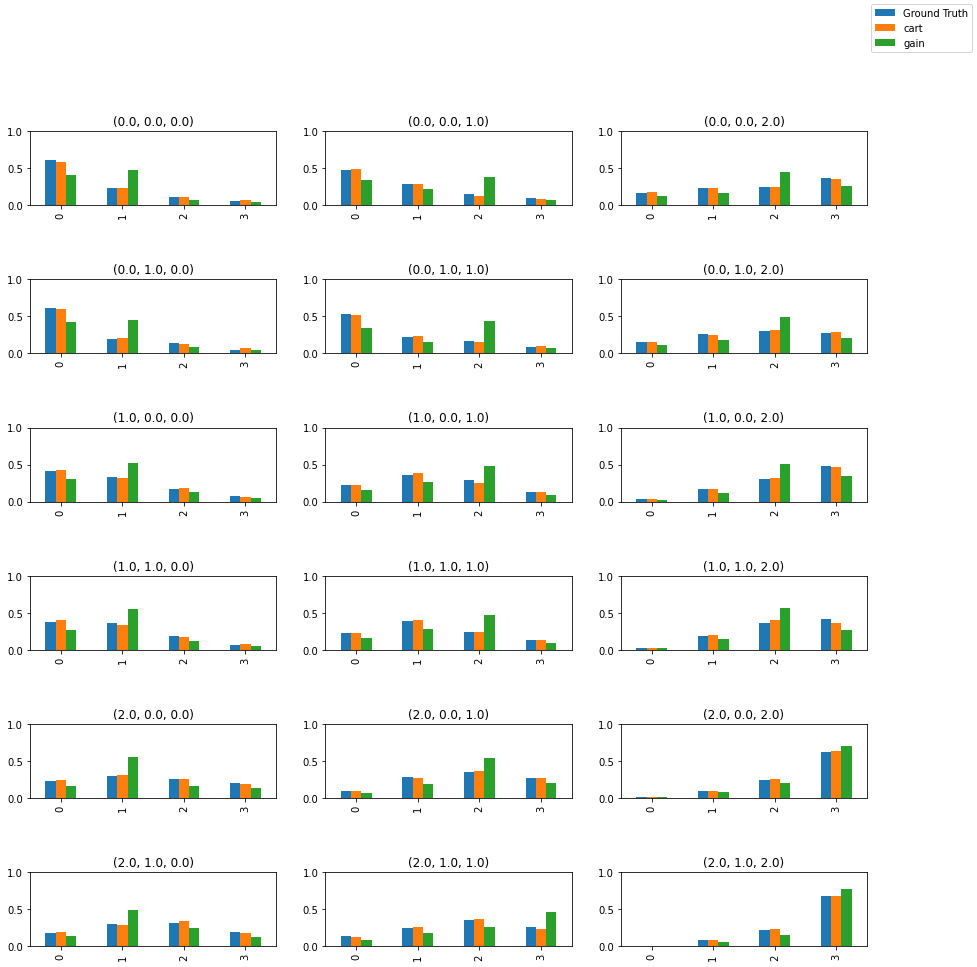

In [103]:
method_list = ['cart','gain']
cd_plots(cond_dist_complete, cond_dist_imputed,method_list, 6,3)